In [1]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
sys.path.append('../neurokin/')
from neurokin.utils.neural import processing, importing
from neurokin.utils.experiments import neural_states_helper, neural_correlates_plot, spider_factory
from neurokin.locomotion_states import NeuralCorrelatesStates
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import arviz as az
import seaborn as sns
from scipy.stats import ttest_ind, ttest_rel

In [2]:
experiment_path = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural"
outputfolder = "./output_neural_correlates/"

NFFT = 2**12
NOV = int(NFFT/4)
TIME_CUTOFF = 1.5


pda = ["NWE00053", "NWE00054", "NWE00130", "NWE00160", "NWE00161", "NWE00162", "NWE00163", "NWE00164"]
skip_animals = ["NWE00053", "NWE00054", "NWE00052"]

CHANNEL_DICT = {"NWE00052": 6,
                "NWE00053": 1,
                "NWE00054": 1,
                "NWE00089": 1,
                "NWE00090": 1,
                "NWE00092": 1,
                "NWE00093": 1,
                "NWE00130": 3,
                "NWE00131": 2,
                "NWE00158": 3,
                "NWE00159": 3,
                "NWE00166": 3,
                "NWE00160": 3,
                "NWE00161": 3,
                "NWE00162": 3,
                "NWE00163": 3,
                "NWE00164": 3}

experiment_structure_path = experiment_path + "/experiment_structure.yaml"
conditions = ["baseline"]

In [3]:
data_structure = {}
input_folder = experiment_path
# Build the structure
days = [i for i in next(os.walk(input_folder))[1]]
for day in days:
    day_path = os.path.join(input_folder, day)
    animals = next(os.walk(day_path))[1]
    data_structure[day] = {}  # Initialize the day dictionary
    for animal in animals:
        animal_path = os.path.join(day_path, animal)
        runways = [f"{f.name}" for f in os.scandir(animal_path) if f.is_dir()]
        data_structure[day][animal] = {"baseline": runways}

# Write the structure to a YAML file
output_yaml = "./experiment_structure.yaml"
with open(output_yaml, "w") as yaml_file:
    yaml.dump(data_structure, yaml_file, default_flow_style=False)

In [4]:
ncs = NeuralCorrelatesStates(timeslice=TIME_CUTOFF,
                            experiment_structure_filepath=output_yaml,
                            skip_subjects=skip_animals)

In [5]:
ncs.create_events_dataset(experiment_path, verbose=False, file_starts_with="runway")

In [6]:
ncs.events_dataset

,date,subject,condition,run,event_gait,event_nlm_rest,event_nlm_active,event_fog_rest,event_fog_active
0,230303,NWE00090,baseline,05,"[[6.425, 9.23]]","[[6.4, 6.42]]","[[9.225, 9.85]]",[],[]
1,230303,NWE00090,baseline,08,"[[3.805, 7.625]]","[[0.005, 3.8]]","[[7.62, 12.45]]",[],[]
2,230303,NWE00090,baseline,11,[],"[[6.81, 14.54], [23.43, 38.57], [46.58, 60.91]...",[],"[[14.545, 23.435], [38.575, 46.585], [60.915, ...",[]
3,230303,NWE00090,baseline,04,[],"[[4.89, 45.82], [51.45, 70.145], [99.535, 115....",[],"[[45.825, 51.455], [70.15, 90.76], [90.76, 99....",[]
4,230303,NWE00090,baseline,01,"[[5.3, 7.44], [8.975, 11.8]]","[[5.085, 5.295]]","[[7.435, 8.97], [11.795, 11.82]]",[],[]
...,...,...,...,...,...,...,...,...,...
179,230504,NWE00166,baseline,09,"[[1.935, 3.725]]","[[1.88, 1.93]]","[[3.72, 3.725]]",[],[]
180,230504,NWE00166,baseline,06,"[[2.665, 4.4]]","[[2.54, 2.66]]","[[4.395, 4.43]]",[],[]
181,230504,NWE00166,baseline,03,"[[2.485, 4.24]]","[[2.25, 2.48]]","[[4.235, 4.26]]",[],[]
182,230504,NWE00166,baseline,10,"[[2.465, 4.17]]","[[2.315, 2.46]]","[[4.165, 4.395]]",[],[]


In [7]:
events_percentage = ncs.events_dataset.copy()
events_percentage = neural_states_helper.condense_distribution_event_types(events_percentage)
events_percentage = neural_states_helper.compute_events_percentage(events_percentage)

events_percentage["group"] = events_percentage["subject"].apply(lambda x: x in pda)
events_percentage["group"] = events_percentage["subject"].apply(lambda x: x in pda)
events_percentage.drop(["condition", "subject"], axis=1, inplace=True)

/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  durations[events_col] = durations[events_col].applymap(compute_duration).apply(compute_percentage, axis=1)


In [8]:
state = "event_fog"

data1 = events_percentage[events_percentage["group"]==True][state]
data2 = events_percentage[events_percentage["group"]==False][state]
pval_fog = ttest_ind(data1, data2).pvalue

state = "event_nlm"

data1 = events_percentage[events_percentage["group"]==True][state]
data2 = events_percentage[events_percentage["group"]==False][state]
pval_nlm = ttest_ind(data1, data2).pvalue


state = "event_gait"

data1 = events_percentage[events_percentage["group"]==True][state]
data2 = events_percentage[events_percentage["group"]==False][state]
pval_gait = ttest_ind(data1, data2).pvalue

In [9]:
def bonferroni_holm(pvals, alpha):
    sortind = np.argsort(pvals)
    pvals = np.take(pvals, sortind)
    ntests = len(pvals)
    alphacSidak = 1 - np.power((1. - alpha), 1./ntests)
    alphacBonf = alpha / float(ntests)
    notreject = pvals > alpha / np.arange(ntests, 0, -1)
    nr_index = np.nonzero(notreject)[0]
    if nr_index.size == 0:
        # nonreject is empty, all rejected
        notrejectmin = len(pvals)
    else:
        notrejectmin = np.min(nr_index)
    notreject[notrejectmin:] = True
    reject = ~notreject
    pvals_corrected_raw = pvals * np.arange(ntests, 0, -1)
    pvals_corrected = np.maximum.accumulate(pvals_corrected_raw)
    pvals_corrected_ = np.empty_like(pvals_corrected)
    pvals_corrected_[sortind] = pvals_corrected
    reject_ = np.empty_like(reject)
    reject_[sortind] = reject
    return reject_, pvals_corrected_, alphacSidak, alphacBonf

In [10]:
pvals = np.asarray([pval_fog, pval_nlm, pval_gait])
reject_, pvals_corrected_, alphacSidak, alphacBonf =  bonferroni_holm(pvals, alpha=0.05)
reject_

array([ True, False,  True])

In [11]:
ncs.create_raw_neural_dataset(experiment_path,
                                  stream_names=["LFP1", "NPr1", "EOG1"],
                                  ch_of_interest=CHANNEL_DICT)

/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/05/
Found Synapse note file: /sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/05/NWE00090-230303-130021/Notes.txt
read from t=0s to t=24.09s
/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/08/
Found Synapse note file: /sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/08/NWE00090-230303-130420/Notes.txt
read from t=0s to t=15.45s
/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/11/
Found Synapse note file: /sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/11/NWE00090-230303-130628/Notes.txt
read from t=0s to t=87.68s
/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/NWE00090/04/
Found Synapse note file: /sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/230303/

In [12]:
ncs.create_psd_dataset(NFFT, NOV, zscore=True)

In [13]:
stats = ncs.plot_prep_states_distribution(pda, condense=True, stat="std")


/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  durations[events_col] = durations[events_col].applymap(compute_duration).apply(compute_percentage, axis=1)


In [14]:
ncs.psds_correlates_dataset["group"] = ncs.psds_correlates_dataset["subject"].apply(lambda x: x in pda)

In [15]:
np.unique(ncs.psds_correlates_dataset[ncs.psds_correlates_dataset["group"]==False].subject)

array(['NWE00089', 'NWE00090', 'NWE00092', 'NWE00093', 'NWE00131',
       'NWE00158', 'NWE00159', 'NWE00166'], dtype=object)

In [16]:
stats

,group,condition,event_type,mean,lower_bound,upper_bound
0,False,baseline,event_gait,67.644942,45.569443,89.720441
1,True,baseline,event_gait,33.012801,11.344432,54.681170
2,False,baseline,event_fog,2.104409,-1.300373,5.509190
3,True,baseline,event_fog,22.946583,14.562854,31.330313
4,False,baseline,event_nlm,30.250649,11.202525,49.298774
5,True,baseline,event_nlm,44.040615,27.338782,60.742449


In [17]:
ncs.freqs = np.fft.rfftfreq(NFFT, d=1/ncs.fs)

In [18]:
max_freq = 100
min_freq = 5

idx_max = processing.find_closest_index(ncs.freqs, max_freq)
idx_min = processing.find_closest_index(ncs.freqs, min_freq)


In [19]:
df = ncs.plot_prep_psds_dataset(test_sbj_list=pda, condense=True)


/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  psds_means = psds_means.applymap(lambda x: [] if x is None else x)
/home/garullie/base_data_analysis/LMM/../neurokin/neurokin/utils/experiments/neural_states_helper.py:78: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  psds_means[events_col] = psds_means[events_col].applymap(mean_psds, na_action="ignore")


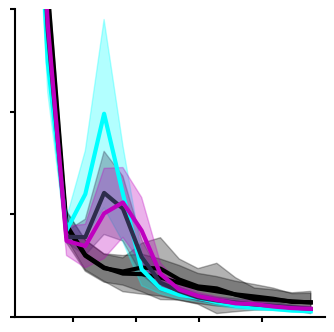

In [22]:
fig, ax = plt.subplots(sharey=True, figsize=(4,4))
colors = ["cyan", "#2e2d4d", "m"]
states = ["event_fog", "event_nlm", "event_gait",]
titles = ["Akinesia", "Stationary \n movement", "Gait"]

neural_correlates_plot.plot_psd_single_state(ax=ax, df=df,  group=False,
                  condition="baseline",
                  state=states[2],
                  freqs=ncs.freqs,
                  color="k",
                  idx_min=idx_min,
                  idx_max=idx_max)
neural_correlates_plot.plot_psd_single_state(ax=ax, df=df,  group=False,
                  condition="baseline",
                  state=states[1],
                  freqs=ncs.freqs,
                  color="k",
                  idx_min=idx_min,
                  idx_max=idx_max)

# Plot Parkinson's animals
for i in range(3):
    neural_correlates_plot.plot_psd_single_state(ax=ax, df=df, group=True,
                      condition="baseline",
                      state=states[i],
                      freqs=ncs.freqs,
                      color=colors[i],
                      idx_min=idx_min,
                      idx_max=idx_max)
    ax.set_xlabel("Freqs [Hz]", fontsize=15)
    #ax.set_title(f"{titles[i]}")

# Plot Sham animals

ylim = 18 #zscore

ax.set_ylabel("PSD [AU]", fontsize=15)
ax.set_ylim(0, ylim)

ax.spines[['right', 'top']].set_visible(False)
ax.set_yticks(ax.get_yticks()[::3],labels=[])
ax.set_xticks([20, 40, 60, 80], [])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

plt.savefig("psd.svg", transparent=True)

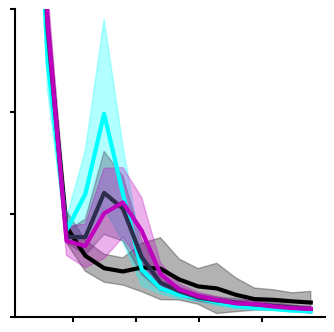

In [21]:
fig, ax = plt.subplots(sharey=True, figsize=(4,4))
colors = ["cyan", "#2e2d4d", "m"]
states = ["event_fog", "event_nlm", "event_gait",]
titles = ["Akinesia", "Stationary \n movement", "Gait"]

neural_correlates_plot.plot_psd_single_state(ax=ax, df=df,  group=False,
                  condition="baseline",
                  state=states[1],
                  freqs=ncs.freqs,
                  color="k",
                  idx_min=idx_min,
                  idx_max=idx_max)

# Plot Parkinson's animals
for i in range(3):
    neural_correlates_plot.plot_psd_single_state(ax=ax, df=df, group=True,
                      condition="baseline",
                      state=states[i],
                      freqs=ncs.freqs,
                      color=colors[i],
                      idx_min=idx_min,
                      idx_max=idx_max)
    ax.set_xlabel("Freqs [Hz]", fontsize=15)
    #ax.set_title(f"{titles[i]}")

# Plot Sham animals

ylim = 18 #zscore

ax.set_ylabel("PSD [AU]", fontsize=15)
ax.set_ylim(0, ylim)

ax.spines[['right', 'top']].set_visible(False)
ax.set_yticks(ax.get_yticks()[::3],labels=[])
ax.set_xticks([20, 40, 60, 80], [])
ax.set_ylabel("")
ax.set_xlabel("")
ax.spines[['right', 'top']].set_visible(False)
ax.spines[["left", "bottom"]].set_linewidth(1.5)
ax.tick_params(width=1.5)

#plt.savefig("psd.svg", transparent=True)

In [30]:
def compute_beta_mean(data, idx_min, idx_max):
    try:
        return np.mean(np.asarray(data).mean(axis=0)[idx_min:idx_max])
    except IndexError:
        return None

In [42]:
df = ncs.psds_correlates_dataset.copy()
df = neural_states_helper.condense_distribution_event_types(df)
df["group"] = df["subject"].apply(lambda x: x in pda)
beta_df = pd.DataFrame(columns=states)

In [43]:
idx_max = processing.find_closest_index(ncs.freqs, 42)
idx_min = processing.find_closest_index(ncs.freqs, 20)


beta_df[states] = df[states].applymap(compute_beta_mean, na_action="ignore", idx_min=idx_min, idx_max=idx_max)
beta_df["group"] = df["group"]
beta_df["subject"]	= df["subject"]
#beta_df["run_id"]	= df["date"] + "_" + df["run"]
beta_df = beta_df[beta_df["group"]==True]
beta_df.drop("group", inplace=True, axis=1)

/tmp/ipykernel_211803/1995449671.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  beta_df[states] = df[states].applymap(compute_beta_mean, na_action="ignore", idx_min=idx_min, idx_max=idx_max)
/tmp/ipykernel_211803/2629789149.py:3: RuntimeWarning: Mean of empty slice.
  return np.mean(np.asarray(data).mean(axis=0)[idx_min:idx_max])
/home/garullie/.conda/envs/cebra/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [48]:
beta_mean = beta_df.groupby("subject").mean()

beta_long = beta_mean.melt(var_name='event', value_name='beta')

In [53]:
beta_long

,event,beta
0,event_fog,11.691596
1,event_fog,7.604901
2,event_fog,10.209879
3,event_fog,7.409137
4,event_fog,3.719200
5,event_fog,5.352156
6,event_nlm,6.493362
7,event_nlm,6.563941
8,event_nlm,7.747563
9,event_nlm,5.105636


In [64]:
state = "event_fog"
comp = "event_nlm"
data1 = beta_long[beta_long["event"]==state]["beta"]
data2 = beta_long[beta_long["event"]==comp]["beta"]
pval_fog_nlm = ttest_rel(data1, data2).pvalue

state = "event_nlm"
comp = "event_gait"
data1 = beta_long[beta_long["event"]==state]["beta"]
data2 = beta_long[beta_long["event"]==comp]["beta"]
pval_nlm_gait = ttest_rel(data1, data2).pvalue


state = "event_gait"
comp = "event_fog"
data1 = beta_long[beta_long["event"]==state]["beta"]
data2 = beta_long[beta_long["event"]==comp]["beta"]
pval_gait_fog = ttest_rel(data1, data2).pvalue

In [65]:
pval_fog_nlm

0.03678592822356493

In [68]:
pval_gait_fog

0.05039064587258988

In [69]:
pvals = np.asarray([pval_fog_nlm, pval_gait_fog])
reject_, pvals_corrected_, alphacSidak, alphacBonf =  bonferroni_holm(pvals, alpha=0.05)
reject_

array([False, False])

In [70]:
pvals_corrected_

array([0.07357186, 0.07357186])

In [83]:
beta_mean

,event_fog,event_nlm,event_gait
subject,,,
NWE00130,11.691596,6.493362,5.973922
NWE00160,7.604901,6.563941,4.769428
NWE00161,10.209879,7.747563,8.125233
NWE00162,7.409137,5.105636,4.378504
NWE00163,3.719200,3.427806,3.154140
NWE00164,5.352156,4.437316,5.908007


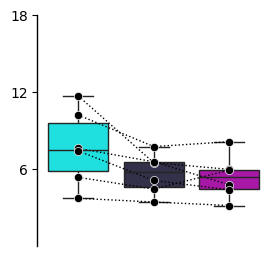

In [88]:
fig, axs = plt.subplots(figsize=(3,3), sharey=True)
sns.boxplot(data=beta_long, y="beta", x="event", hue="event",  ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False)
chart = sns.scatterplot(data=beta_long, y="beta", x="event", ax=axs, color="k", legend=False, s=35, zorder=10)

for sbj in beta_mean.index:
    axs.plot(["event_fog", "event_nlm", "event_gait"], [beta_mean.loc[sbj]["event_fog"],
                                                       beta_mean.loc[sbj]["event_nlm"],
                                                       beta_mean.loc[sbj]["event_gait"]], color="k", linewidth=1, linestyle=":")


axs.set_ylabel("")
axs.set_xlabel("")
axs.set_ylim(0,18)
axs.set_yticks([6, 12, 18])
axs.set_xticks([])
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_linewidth(1)

plt.savefig("psd_boxplot.svg", transparent=True)

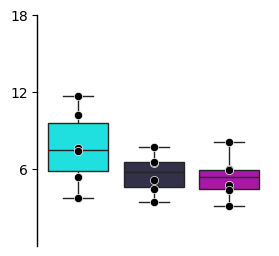

In [79]:
fig, axs = plt.subplots(figsize=(3,3), sharey=True)
sns.boxplot(data=beta_long, y="beta", x="event", hue="event",  ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False)
chart = sns.scatterplot(data=beta_long, y="beta", x="event", ax=axs, color="k", legend=False, s=35, zorder=10)
axs.set_ylabel("")
axs.set_xlabel("")
axs.set_ylim(0,18)
axs.set_yticks([6, 12, 18])
axs.set_xticks([])
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_linewidth(1)

In [ ]:

    fig, axs = plt.subplots(figsize=(3,3), sharey=True)
    sns.boxplot(data=groups_mean, y=cond, x="event", hue="event",  ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False)
    chart = sns.scatterplot(data=groups_mean, y=cond, x="event", ax=axs, color="k", legend=False, s=35, zorder=10)
    
    y = 1.85
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        significance = "* " if pval<sl else ""
        p = f"p={pval:.2f}" if pval<sl else ""

        h, col = 0.05, 'k'
        chart.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col, solid_capstyle="round")
        chart.text((x1+x2)*.5, y-0.05,  f"{significance}", 
                       ha='center', va='bottom', color=col, fontsize=font+5)
        y-=0.25


    fn = neu[i].replace("_", " ")
    spaces = [m.start() for m in re.finditer(' ', fn)]
    if len(spaces)>2:
        split_space = spaces[int(len(spaces)/2)]
        fn = f"{fn[:split_space]} \n {fn[split_space+1:]}"
    axs.set_title(fn, y=1.2)
    axs.set_ylabel("")
    axs.set_xlabel("")
    axs.set_yticks([-1.5, 0, 1.5])
    axs.set_xticks([])
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_linewidth(3)

    #plt.savefig(f"./group_comp/{cond}.png", transparent=True)
    #plt.savefig(f"./group_comp/{cond}.svg", transparent=True)